In [3]:
# General 
import sys
import math
import numpy as np
import pandas as pd
#Plotting
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import cm
#GPyTorch
import torch
import gpytorch
from torch.utils.data import TensorDataset, DataLoader
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy
import tqdm
#Sklearn 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# Load the data

In [4]:
class ExperimentData:
    def __init__(self,filepath,name):
        self.filepath = filepath 
        self.name = name
        self.read_data(filepath)
        # Initialize GP hyperparameters
        self.length_scale = [1, 1]
        self.sigma_f = 0.5
        self.sigma_n = 0.1
        self.kernel_dict = {}
        self.prediction_dict = {}
        
    def read_data(self, array_type="None"):
        training_data = pd.read_csv(self.filepath)
        training_data_array = training_data.to_numpy()
        # Return torch array type needed for training with GPyTorch
        if array_type == 'torch':
            self.X = torch.FloatTensor(np.stack((training_data_array[:, 0], training_data_array[:, 1]), axis=-1))
            self.y = torch.FloatTensor(training_data_array[:, 2:4])
        # Otherwise just load numpy array
        else:
            self.X = np.stack((training_data_array[:, 0], training_data_array[:, 1]), axis=-1)
            self.y = training_data_array[:, 2:4]
        # Test_train_split
        self.test_train_split()
        
    def test_train_split(self):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.2, random_state=1)
    
    def save_kernel_params(self, name, length_scale, sigma_f, variance, sigma_n):
        self.kernel_dict[name] =  [length_scale[0], length_scale[1], sigma_f, variance, sigma_n]
        
    def save_prediction(self, name, mean, upper, lower):
        self.prediction_dict[name] = [mean, upper, lower]
    
    # Plotting functions
    def plot_input_data(self):
        fig, axs = plt.subplots(2, 3)
        fig.set_size_inches(18.5, 10.5)
        axs[0, 0].remove()
        ax1 = fig.add_subplot(2, 3, 1, projection='3d')
        ax1.scatter(self.X[:, 0], self.X[:, 1], self.y[:,0])
        axs[0, 1].plot(self.X[:,0], self.y[:,0], 'r*')
        axs[0, 1].set_xlabel("x-direction[m]")
        axs[0, 1].set_ylabel("force in x-direction [m/s^2]")
        axs[0, 2].plot(self.X[:,1], self.y[:,0], 'g*')
        axs[0, 2].set_xlabel("y-direction[m]")
        axs[0, 2].set_ylabel("force in x-direction [m/s^2]")
        axs[1, 0].remove()
        ax4 = fig.add_subplot(2, 3, 4, projection='3d')
        ax4.scatter(self.X[:, 0], self.X[:, 1], self.y[:,1])
        axs[1, 1].plot(self.X[:, 0], self.y[:,1], 'r*')
        axs[1, 1].set_xlabel("x-direction[m]")
        axs[1, 1].set_ylabel("force in y-direction [m/s^2]")
        axs[1, 2].plot(self.X[:, 1], self.y[:,1], 'g*')
        axs[1, 2].set_xlabel("y-direction[m]")
        axs[1, 2].set_ylabel("force in y-direction [m/s^2]")
        fig.suptitle(self.name)
        plt.show()
        
    def plot_wind_field(self, X=None, y=None, res=8, title=None):
        fig, ax = plt.subplots(1, 1)
        plt.axis('equal')
        plt.grid(linestyle=':')
        if X is None:
            X = self.X
            y = self.y
            title = self.name
        q = plt.quiver(X[::res, 0], X[::res, 1], y[::res,0], y[::res,1], scale=2.54, color='r',
                       units='width', scale_units="inches", width=0.003)
        plt.title(title)
        plt.ioff()
        plt.show()

In [122]:
experiment_data_dict = \
    {"Lemniscate with two random fans": 
         "/home/johanna/MasterThesis/Wind_data/sim_data/lmpcc_windsimplesim_fan_xy_random_2022-09-07-10-52-31.csv",
     "Lemniscate with one fan in x direction": 
         "/home/johanna/MasterThesis/Wind_data/sim_data/lmpcc_windsimplesim_fan_x_dir_2022-09-07-10-45-44.csv",
     "Lemniscate with one fan in y direction":
         "/home/johanna/MasterThesis/Wind_data/sim_data/lmpcc_windsimplesim_fan_y_dir_2022-09-14-15-02-36.csv",
     "Lemniscate with four random fans":
         "/home/johanna/MasterThesis/Wind_data/sim_data/lmpcc_windsimplesim_4_fans_2022-09-14-15-09-36.csv",
     "Random trajectory with four random fans":
         "/home/johanna/MasterThesis/Wind_data/sim_data/lmpcc_windsimplesim_4_fans_random_path1_2022-09-14-15-46-56.csv",
     "Lemniscate with two fans in x-y direction":
         "/home/johanna/MasterThesis/Wind_data/sim_data/lmpcc_windsimplesim_fan_xy_dir_2022-09-07-10-48-53.csv",
     "Line path combined":
         "/home/johanna/MasterThesis/Wind_data/sim_data/lmpcc_windsimplesim_fan_xy_random_line_path_combined.csv",
     "Structured path":
         "/home/johanna/MasterThesis/Wind_data/sim_data/lmpcc_windsimplesim_y_dir_structured_path_2022-09-17-16-31-10.csv",
     "Structured path":
         "/home/johanna/MasterThesis/Wind_data/sim_data/lmpcc_windsimplesim_2_fans_random_structured_path_2022-09-17-16-52-26.csv",
     "Structured path tsp":
         "/home/johanna/MasterThesis/Wind_data/sim_data/lmpcc_windsimplesim_2_fans_random_tsp_path_2022-09-21-12-11-10.csv",
     "Structured path with custom controller":
         "/home/johanna/MasterThesis/Wind_data/sim_data/simplecontrol_windsimplesim_2_fans_random_tsp_path_2022-09-25-13-14-59.csv",
     "Structured path with custom controller 2":
         "/home/johanna/MasterThesis/Wind_data/sim_data/simplecontrol_windsimplesim_2_fans_random_tsp_path_combined.csv"
    }

/tmp/ipykernel_26950/545992419.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 1)


<IPython.core.display.Javascript object>


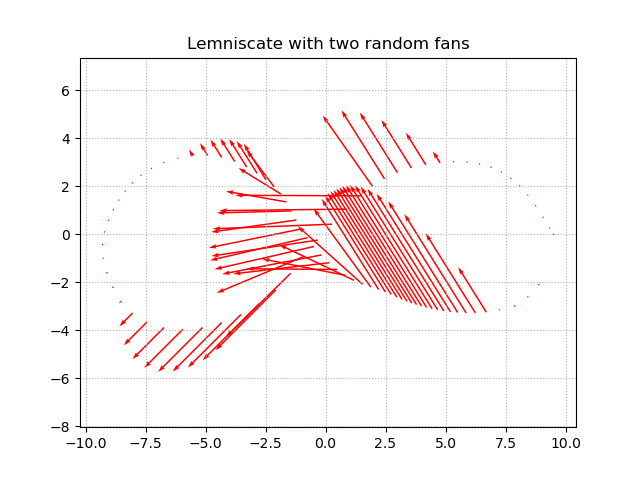

<IPython.core.display.Javascript object>


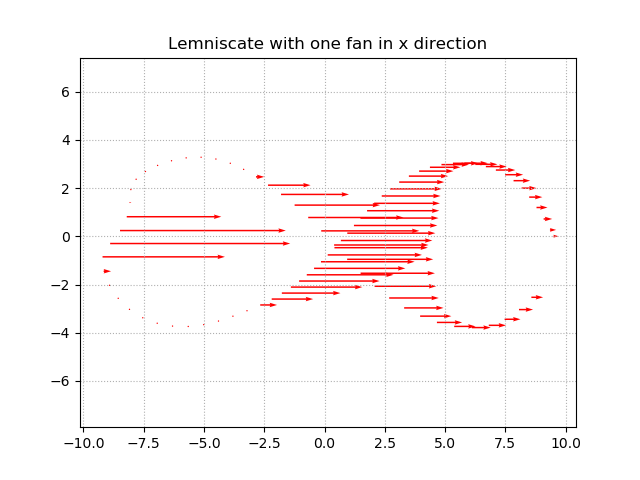

<IPython.core.display.Javascript object>


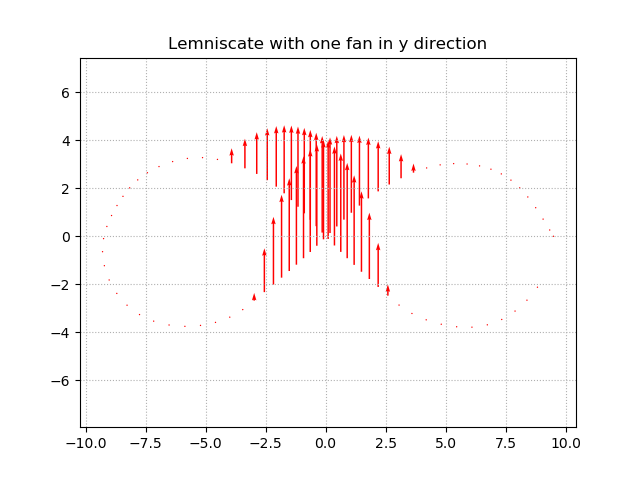

<IPython.core.display.Javascript object>


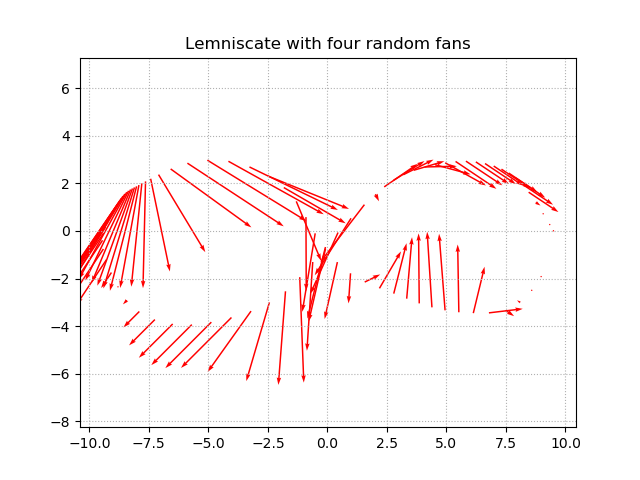

<IPython.core.display.Javascript object>


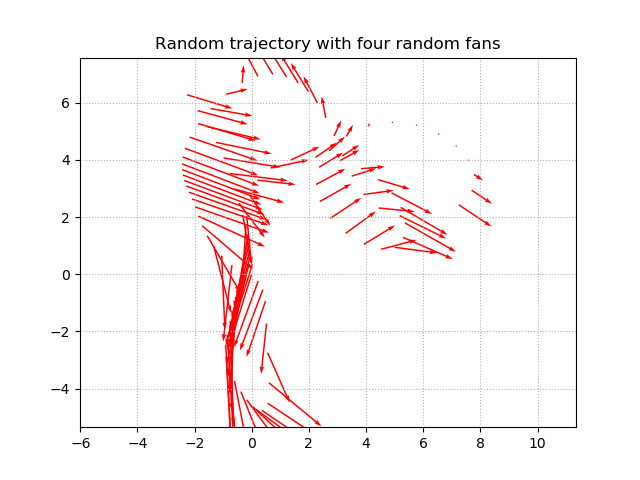

<IPython.core.display.Javascript object>


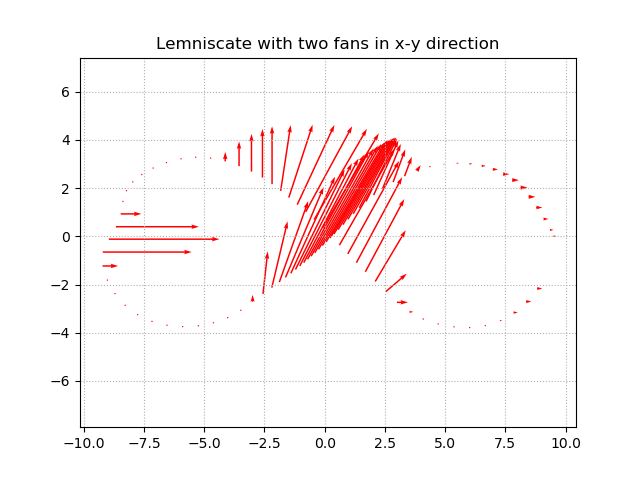

<IPython.core.display.Javascript object>


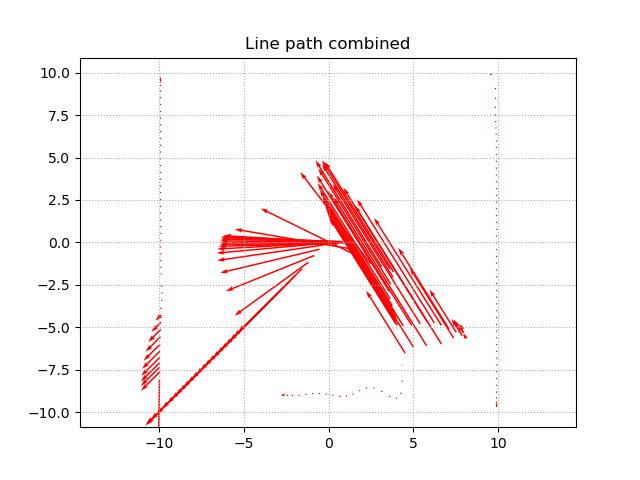

<IPython.core.display.Javascript object>


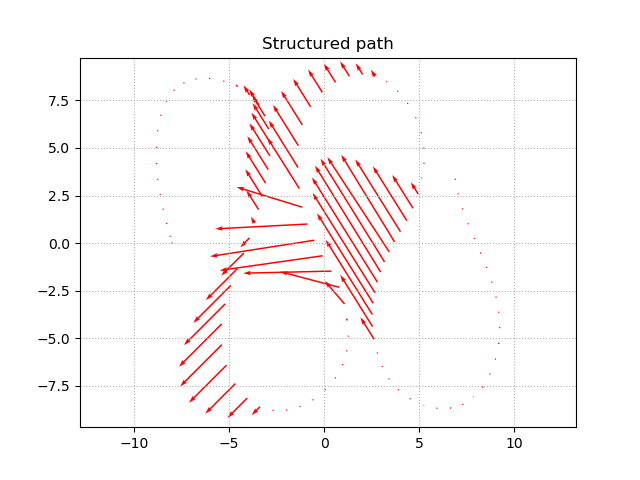

<IPython.core.display.Javascript object>


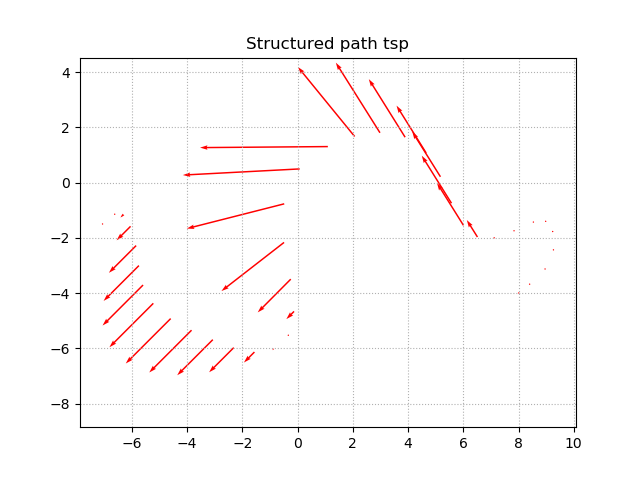

<IPython.core.display.Javascript object>


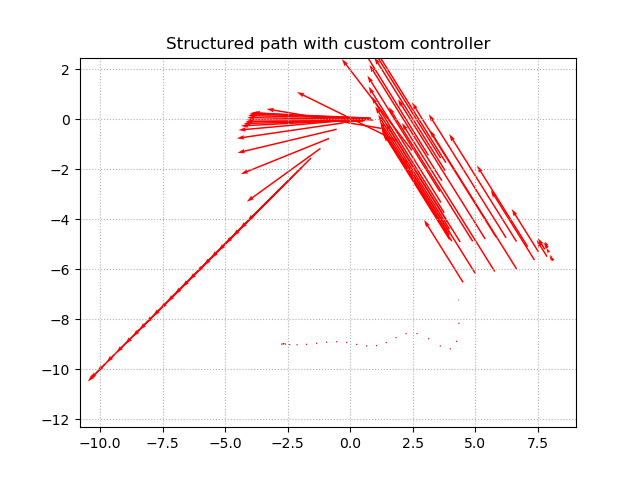

<IPython.core.display.Javascript object>


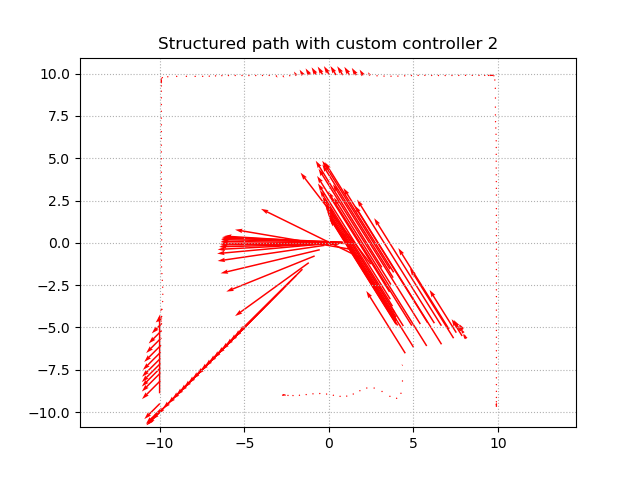

In [123]:
experiment_data = []
for experiment in experiment_data_dict:
    data = ExperimentData(experiment_data_dict[experiment], experiment)
    experiment_data.append(data)
for i in range(len(experiment_data)):
    # experiment_data[i].plot_input_data()
    experiment_data[i].plot_wind_field()

In [161]:
data = experiment_data[-1]

## Plot the inducing points

<IPython.core.display.Javascript object>


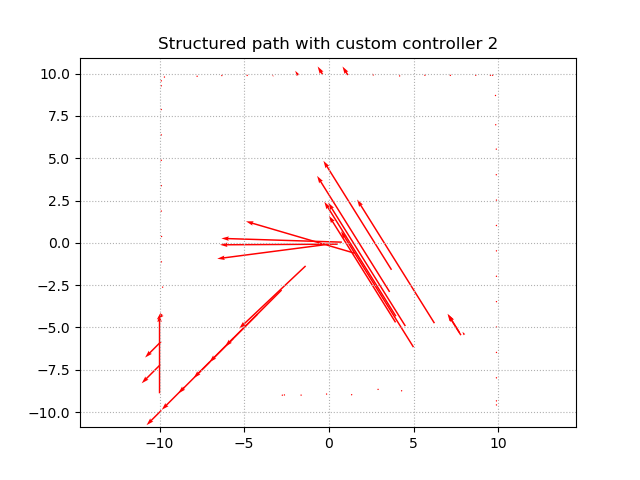

In [162]:
p_ind = 30
data.plot_wind_field(res=30)

In [163]:
p_ind

30

# Sparse GPs with GPyTorch

In [164]:
class GPModel(ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=True)
        super(GPModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ZeroMean()
        #self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=2))
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=1.5, ard_num_dims=2) + gpytorch.kernels.LinearKernel(num_dimensions=2))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [165]:
class SparseGPyTorchRegression:
    def __init__(self, data, batch_size, epochs):
        # Change dataset to torch tensor
        self.data = data
        data.read_data("torch")
        self.likelihood = []
        self.model = []
        self.batch_size = batch_size
        self.n_epochs = epochs
    def fit(self):
        for i in range(data.y.shape[1]):
            train_dataset = TensorDataset(data.X_train, data.y_train[:,i])
            train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
            inducing_points = data.X_train[:p_ind, :]
            model = GPModel(inducing_points=inducing_points)
            likelihood = gpytorch.likelihoods.GaussianLikelihood()
            model.train()
            likelihood.train()
            # Use the adam optimizer
            optimizer = torch.optim.Adam([
                {'params': model.parameters()},
                {'params': likelihood.parameters()},
            ], lr=0.01)
            # "Loss" for GPs - the marginal log likelihood
            mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=data.y_train[:,i].size(0))
            num_epochs = self.n_epochs
            epochs_iter = tqdm.notebook.tqdm(range(num_epochs), desc="Epoch")
            for i in epochs_iter:
                # Within each iteration, we will go over each minibatch of data
                minibatch_iter = tqdm.notebook.tqdm(train_loader, desc="Minibatch", leave=False)
                for x_batch, y_batch in minibatch_iter:
                    optimizer.zero_grad()
                    output = model(x_batch)
                    loss = -mll(output, y_batch)
                    minibatch_iter.set_postfix(loss=loss.item())
                    loss.backward()
                    optimizer.step()
            self.likelihood.append(likelihood)
            self.model.append(model)
        self.save_kernel_params()
        
    def get_kernel_params(self):
        self.sigma_f = []
        self.length_scale = []
        self.variance = []
        self.sigma_n = []
        for i in range(data.y.shape[1]):
            self.sigma_f.append(self.model[i].covar_module.outputscale.item())
            self.length_scale.append([self.model[i].covar_module.base_kernel.kernels[0].lengthscale.detach().numpy().item(0),
                                      self.model[i].covar_module.base_kernel.kernels[0].lengthscale.detach().numpy().item(1)])
            self.variance.append(self.model[i].covar_module.base_kernel.kernels[1].variance.item())
            self.sigma_n.append(self.likelihood[i].noise_covar.noise.item())
    def save_kernel_params(self):
        self.get_kernel_params()
        for i in range(data.y.shape[1]):
            name = "gpytorch_y" + str(i+1) + "_" + str(self.batch_size) + "_" + str(self.n_epochs)
            self.data.save_kernel_params(name, self.length_scale[i], self.sigma_f[i], self.variance[i], self.sigma_n[i])
    def predict(self, X_test=data.X_test):
        self.mean = np.empty(X_test.shape)
        self.upper = np.empty(X_test.shape)
        self.lower = np.empty(X_test.shape)
        for i in range(data.y.shape[1]):
            self.model[i].eval()
            self.likelihood[i].eval()
            observed_pred = (self.model[i](X_test))
            self.mean[:,i] = observed_pred.mean.detach().numpy()
            lower, upper = observed_pred.confidence_region()
            self.upper[:,i] = lower.detach().numpy()
            self.lower[:,i] = upper.detach().numpy()
        name = "gpytorch" + "_" + str(self.batch_size) + "_" + str(self.n_epochs)
        self.data.save_prediction(name, self.mean, self.upper, self.lower)

In [166]:
data.read_data("torch")
sparse_gp_torch = SparseGPyTorchRegression(data, 20, 20)
sparse_gp_torch.fit()
sparse_gp_torch.predict()

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/85 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/85 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/85 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/85 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/85 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/85 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/85 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/85 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/85 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/85 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/85 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/85 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/85 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/85 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/85 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/85 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/85 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/85 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/85 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/85 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/85 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/85 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/85 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/85 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/85 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/85 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/85 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/85 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/85 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/85 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/85 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/85 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/85 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/85 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/85 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/85 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/85 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/85 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/85 [00:00<?, ?it/s]

# Investigate training parameters

In [129]:
batch_size_list = [5,10,20,50,100]
n_epochs_list = [2,5,10,20,50,100]
for i in range(len(batch_size_list)):
    for j in range(len(n_epochs_list)):
        sparse_gp_torch = SparseGPyTorchRegression(data, batch_size_list[i], n_epochs_list[j])
        sparse_gp_torch.fit()

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/131 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/131 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Evaluation

In [167]:
df = pd.DataFrame(data.kernel_dict.values(), columns=["l1", "l2", "sigma_f", "variance", "sigma_n"])
df.insert(0, "Training_algorithm", data.kernel_dict.keys())
df

,Training_algorithm,l1,l2,sigma_f,variance,sigma_n
0,gpytorch_y1_20_20,5.847627,5.147662,0.390475,0.462828,0.177181
1,gpytorch_y2_20_20,3.965134,3.721344,0.353635,0.460165,0.273931


In [168]:
data.prediction_dict.keys()

dict_keys(['gpytorch_20_20'])

In [169]:
def create_grid(start, stop, res, array_type = None):
    x = np.linspace(start, stop, res)
    y = np.linspace(start, stop, res)
    x, y = np.meshgrid(x, y)
    if array_type is None:
        X = np.stack((x.flatten(), y.flatten()), axis=-1)
    else:
        X = torch.FloatTensor(np.stack((x.flatten(), y.flatten()), axis=-1))
    return X, x, y
X_grid, x_grid, y_grid = create_grid(-10,9.9,51)
X_grid_torch, x_grid_torch, y_grid_torch = create_grid(-10,9.9,51, "torch")

<IPython.core.display.Javascript object>


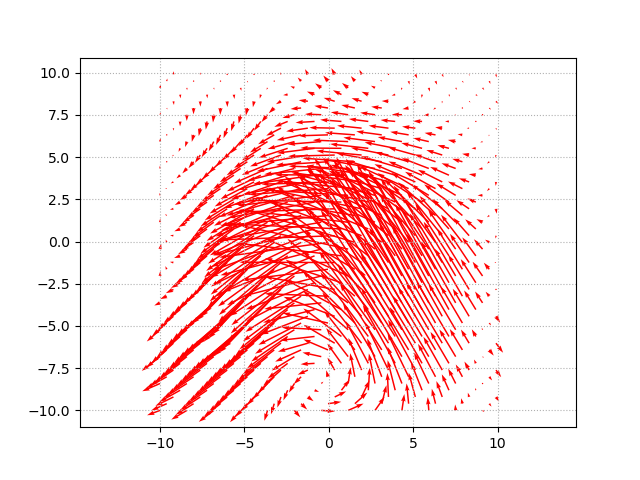

In [170]:
sparse_gp_torch.predict(X_grid_torch)
data.plot_wind_field(X_grid_torch, sparse_gp_torch.mean, 4)

In [171]:
# Plot the uncertainties
def plot_surface(x, y, mean, upper, lower, bounds):
    mean_grid = mean.reshape(x.shape)
    fig = plt.figure()
    if bounds:
        upper_grid = upper.reshape(x.shape)
        lower_grid = lower.reshape(x.shape)
        ax = fig.gca(projection='3d')
        ax.plot_surface(x, y, mean_grid,  color='C0', alpha=0.8)
        ax.plot_surface(x, y, upper_grid, cmap=cm.coolwarm, alpha=0.5)
        ax.plot_surface(x, y, lower_grid, cmap=cm.coolwarm, alpha=0.5)
    else:
        ax1 = fig.subplots(1, 1)
        ax1 = plt.contourf(x, y, mean_grid)
        plt.colorbar(ax1)
    plt.ioff()
    plt.show()

Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py", line 216, in process
    func(*args, **kwargs)
  File "/usr/lib/python3/dist-packages/matplotlib/backends/backend_nbagg.py", line 236, in <lambda>
    canvas.mpl_connect('close_event', lambda event: Gcf.destroy(num))
  File "/usr/lib/python3/dist-packages/matplotlib/_pylab_helpers.py", line 53, in destroy
    cls._activeQue.remove(manager)
ValueError: list.remove(x): x not in list
Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py", line 216, in process
    func(*args, **kwargs)
  File "/usr/lib/python3/dist-packages/matplotlib/backends/backend_nbagg.py", line 236, in <lambda>
    canvas.mpl_connect('close_event', lambda event: Gcf.destroy(num))
  File "/usr/lib/python3/dist-packages/matplotlib/_pylab_helpers.py", line 53, in destroy
    cls._activeQue.remove(manager)
ValueError: list.remove(x): x not in list
Traceback (most recent

<IPython.core.display.Javascript object>


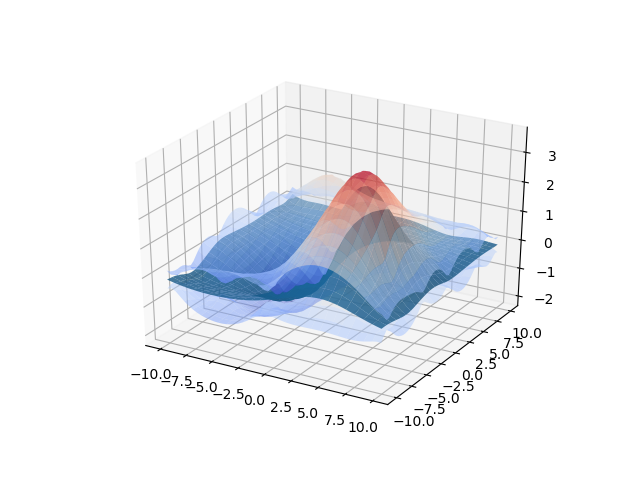

<IPython.core.display.Javascript object>


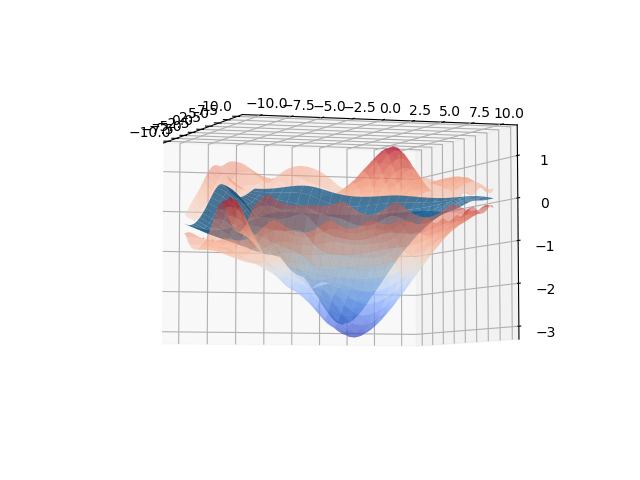

In [172]:
%matplotlib notebook
plot_surface(x_grid, y_grid, sparse_gp_torch.mean[:,1], sparse_gp_torch.upper[:,1], sparse_gp_torch.lower[:,1], True)
plot_surface(x_grid, y_grid, sparse_gp_torch.mean[:,0], sparse_gp_torch.upper[:,0], sparse_gp_torch.lower[:,0], True)

# Query the 10 most uncertain points

In [173]:
unc0 = sparse_gp_torch.upper[:,1] - sparse_gp_torch.mean[:,1]
unc1 = sparse_gp_torch.upper[:,1] - sparse_gp_torch.mean[:,1]

In [174]:
X_grid.size

5202

In [175]:
idx = np.argsort(unc0 + unc1)[0:100]
X_samp = X_grid[idx]
idx

array([2156, 2105, 2155, 2104, 2106, 2157, 2054, 2207, 2055, 2053, 2206,
       2103, 2154, 2107, 2208, 2158, 2056, 2052, 2003, 2004, 2002, 2205,
       2108, 2209, 2102, 2005, 2153, 2057, 2159, 2001, 2051, 2258, 1952,
       1953, 2257, 2006, 1951, 2204, 2259, 1954, 2109, 2000, 2058, 2210,
       1950, 2256, 2101, 1955, 2160, 2152, 2007, 2050, 1901, 1902, 2260,
       1900, 1903, 1949, 1956, 2059, 1999, 2203, 2110, 1899, 1904, 2255,
       2211, 2008, 2161, 1851, 1850, 2261, 2100, 1905, 1957, 1852, 1849,
       1898, 2049, 2151, 1948, 2309, 2060, 1853, 2308, 2009, 1848, 2111,
       1998, 1906, 2310, 2254, 2212, 1854, 1958, 2202, 1800, 2307, 1799,
       2262])

In [176]:
plt.plot(X_samp[:,0],X_samp[:,1], '*')
plt.show()

<IPython.core.display.Javascript object>

In [145]:
from sklearn.cluster import KMeans
idx = np.argsort(unc0 + unc1)[0:100]
X_samp = X_grid[idx]
kmeans = KMeans(n_clusters=5)
kmeans.fit(X_samp)
centers = kmeans.cluster_centers_

<IPython.core.display.Javascript object>


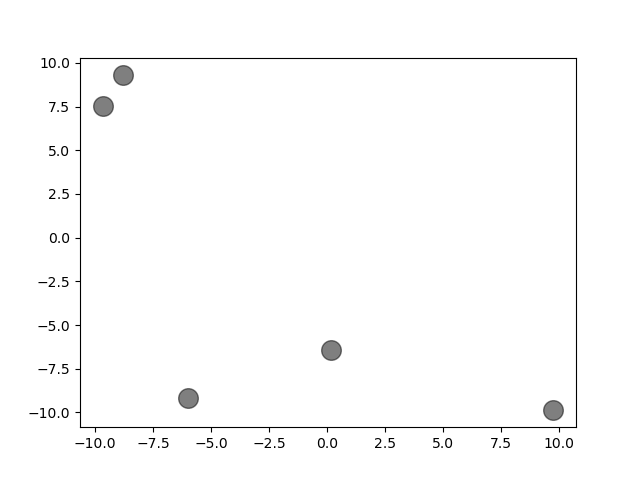

In [146]:
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
plt.show()

## Compare to Ground Thruth

In [27]:
class WindCalculator:
    def __init__(self,windfield_params):
        self.windfield_params = windfield_params
        self.windfield_params = windfield_params
        self.use_custom_windfield = self.windfield_params['use_custom_windfield']
        self.wind_direction = self.windfield_params['wind_direction']
        self.wind_velocity = self.windfield_params['wind_velocity']
        wind_norm = np.sqrt(self.wind_direction[0] ** 2 + self.wind_direction[1] ** 2 + self.wind_direction[2] ** 2)
        self.wind_direction = self.wind_direction / wind_norm
        if self.use_custom_windfield:
            windfield_path= self.windfield_params['windfield_path']
            try:
                f = open(windfield_path)
            except:
                print("File '" + windfield_path + "' does not exist!")
                exit(1)

            name = ""
            data = dict()
            for i in range(26):
                val = f.readline()
                if i % 2 == 0:
                    val = str(val)
                    val = val.replace(" ", "")
                    val = val.replace("\n", "")
                    val = val.replace(":", "")
                    name = val
                else:
                    line = np.fromstring(str(val), sep=" ")
                    if (len(line) == 1):
                        line = line[0]
                    data[name] = line

            self.min_x_ = data["min_x"]
            self.min_y_ = data["min_y"]
            self.n_x_ = int(data["n_x"])
            self.n_y_ = int(data["n_y"])
            self.res_x_ = data["res_x"]
            self.res_y_ = data["res_y"]
            self.vertical_spacing_factors_ = data["vertical_spacing_factors"]
            self.bottom_z_ = data["bottom_z"]
            self.top_z_ = data["top_z"]
            self.u_vec_ = data["u"]
            self.v_vec_ = data["v"]
            self.w_vec_ = data["w"]

            self.n_z = len(self.vertical_spacing_factors_)

    def linear_interpolation(self, position, values, points):
        value = values[0] + (values[1] - values[0]) / (points[1] - points[0]) * (position - points[0])
        return value

    def bilinear_interpolation(self, position, values, points):
        intermediate_values = np.array([self.linear_interpolation(position[0], values[0:], points[0:]),
                                        self.linear_interpolation(position[0], values[2:], points[2:])])
        value = self.linear_interpolation(position[1], intermediate_values, points[4:])
        return value

    def trilinear_interpolation(self, position, values, points):
        intermediate_values = np.array([self.linear_interpolation(position[2], values[0:], points[0:]),
                                        self.linear_interpolation(position[2], values[2:], points[2:]),
                                        self.linear_interpolation(position[2], values[4:], points[4:]),
                                        self.linear_interpolation(position[2], values[6:], points[6:])])
        value = self.bilinear_interpolation(position[0:],intermediate_values, points[8:])
        return value

    def calculate_windfield(self, link_position):

        if self.use_custom_windfield:
            # Calculate x,y index just smaller than aircraft position or equal to
            x_inf = math.floor((link_position[0] - self.min_x_) / self.res_x_)
            y_inf = math.floor((link_position[1] - self.min_y_) / self.res_y_)

            # In case aircraft is on one of the boundary surfaces at max_x or max_y,
            # decrease x_inf, y_inf by one to have x_sup, y_sup on max_x, max_y.
            if x_inf == self.n_x_ - 1:
                x_inf = self.n_x_ - 2
            if y_inf == self.n_y_ - 1:
                y_inf = self.n_y_ - 2

            # Calculate x,y index just larger than aircraft position
            x_sup = x_inf + 1
            y_sup = y_inf + 1

            # Save grid points enclosing the aircraft in an array
            n_vertices = 8
            idx_x = np.array([x_inf, x_inf, x_sup, x_sup, x_inf, x_inf, x_sup, x_sup])
            idx_y = np.array([y_inf, y_inf, y_inf, y_inf, y_sup, y_sup, y_sup, y_sup])

            # Find vertical factors in each of the four surrounding
            # grid columns, and their minimal/maximal value.
            n_columns = 4
            vertical_factors_columns = np.empty(n_columns)
            for i in range(n_columns):
                vertical_factors_columns[i] = (link_position[2] - self.bottom_z_[
                    idx_x[2 * i] + idx_y[2 * i] * self.n_x_]) \
                                              / (self.top_z_[idx_x[2 * i] + idx_y[2 * i] * self.n_x_] -
                                                 self.bottom_z_[idx_x[2 * i] + idx_y[2 * i] * self.n_x_])

            # Find minimal and maximal vertical factor
            vertical_factors_min = min(min(min(
                vertical_factors_columns[0], vertical_factors_columns[1]),
                vertical_factors_columns[2]), vertical_factors_columns[3])
            vertical_factors_max = max(max(max(
                vertical_factors_columns[0], vertical_factors_columns[1]),
                vertical_factors_columns[2]), vertical_factors_columns[3])

            # Check if aircraft is out of wind field or not, and act accordingly.
            if (x_inf >= 0 and y_inf >= 0 and vertical_factors_max >= 0 and
                    x_sup <= (self.n_x_ - 1) and y_sup <= (self.n_y_ - 1) and vertical_factors_min <= 1):
                # Find indices in z-direction for each of the vertices.If link is not
                # within the range of one of the columns, set to lowest or highest two.
                idx_z = [0, int(len(self.vertical_spacing_factors_)) - 1,
                         0, int(len(self.vertical_spacing_factors_)) - 1,
                         0, int(len(self.vertical_spacing_factors_)) - 1,
                         0, int(len(self.vertical_spacing_factors_)) - 1]
                for i in range(n_columns):
                    if vertical_factors_columns[i] < 0:
                        # Link z - position below lowest grid point of that column
                        idx_z[2 * i + 1] = 1
                    elif vertical_factors_columns[i] >= 1:
                        # Link z-position above highest grid point of that column
                        idx_z[2 * i] = len(self.vertical_spacing_factors_) - 2
                    else:
                        # Link z-position between two grid points in that column.
                        for j in range(len(vertical_factors_columns) - 1):
                            if self.vertical_spacing_factors_[j] <= vertical_factors_columns[i] < \
                                    self.vertical_spacing_factors_[j + 1]:
                                idx_z[2 * i] = j
                                idx_z[2 * i + 1] = j + 1
                                break

                # Extract the wind velocities corresponding to each vertex
                wind_at_vertices = np.empty([8, 3])
                for i in range(n_vertices):
                    wind_at_vertices[i, 0] = self.u_vec_[
                        idx_x[i] + idx_y[i] * self.n_x_ + idx_z[i] * self.n_x_ * self.n_y_]
                    wind_at_vertices[i, 1] = self.v_vec_[
                        idx_x[i] + idx_y[i] * self.n_x_ + idx_z[i] * self.n_x_ * self.n_y_]
                    wind_at_vertices[i, 2] = self.w_vec_[
                        idx_x[i] + idx_y[i] * self.n_x_ + idx_z[i] * self.n_x_ * self.n_y_]

                # Extract the relevant coordinate of every point needed for trilinear interpolation
                n_points_interp_z = 8
                n_points_interp_x = 4
                n_points_interp_y = 2
                interpolation_points = np.empty(n_points_interp_x + n_points_interp_y + n_points_interp_z)
                for i in range(n_points_interp_x + n_points_interp_y + n_points_interp_z):
                    if i < n_points_interp_z:
                        interpolation_points[i] = (self.top_z_[idx_x[i] + idx_y[i] * self.n_x_] - self.bottom_z_[
                            idx_x[i] + idx_y[i] * self.n_x_]) \
                                                  * self.vertical_spacing_factors_[idx_z[i]] + self.bottom_z_[
                                                      idx_x[i] + idx_y[i] * self.n_x_]
                    elif n_points_interp_z <= i < n_points_interp_x + n_points_interp_z:
                        interpolation_points[i] = self.min_x_ + self.res_x_ * idx_x[2 * (i - n_points_interp_z)]
                    else:
                        interpolation_points[i] = self.min_y_ + self.res_y_ * idx_y[
                            4 * (i - n_points_interp_z - n_points_interp_x)]

                wind_v = self.trilinear_interpolation(link_position, wind_at_vertices, interpolation_points)
            else:
                print("Drone is outside of specified custom windfield, using default one")
                wind_v = self.wind_direction * self.wind_velocity
        else:
            wind_v = self.wind_direction * self.wind_velocity
        return wind_v

    def return_ground_truth(self):
        mean = []
        x = self.windfield_params['x'].flatten()
        y = self.windfield_params['y'].flatten()
        for i in range(x.size):
            link_position = [x[i], y[i], 2] #Random z parameter for now
            wind_v = self.calculate_windfield(link_position)
            mean.append(wind_v)
        mean = np.array(mean)
        return mean

<IPython.core.display.Javascript object>


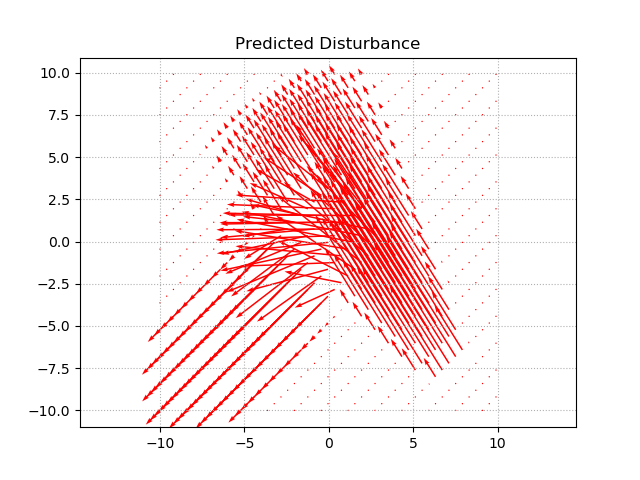

In [28]:
wind_field_parameters = {'use_custom_windfield': True, 'wind_direction': np.array([1.0, 1.0, 0.0]), 'wind_velocity': 1.0, 'x':x_grid, 'y':y_grid, 'windfield_path':'/home/johanna/uav_mpcc/src/model_sim/include/custom_wind_fields/fan_2_fans_random.txt'}
wind_calculator = WindCalculator(wind_field_parameters)
mean_gt = wind_calculator.return_ground_truth()
data.plot_wind_field(X_grid, mean_gt, 4, "Predicted Disturbance")

In [27]:
y_true = mean_gt[:,0:2]
y_pred = sparse_gp_torch.mean
MAE = mean_absolute_error(y_true, y_pred)
MSE = mean_squared_error(y_true, y_pred)
print("GPyTorch: ",MAE, MSE)

GPyTorch:  0.8921461387079095 1.6581923946605617


In [28]:
# Plot the uncertainties
def plot_surface(x, y, mean, upper, lower, bounds):
    mean_grid = mean.reshape(x.shape)
    fig = plt.figure()
    if bounds:
        upper_grid = upper.reshape(x.shape)
        lower_grid = lower.reshape(x.shape)
        ax = fig.gca(projection='3d')
        ax.plot_surface(x, y, mean_grid,  color='C0', alpha=0.8)
        ax.plot_surface(x, y, upper_grid, cmap=cm.coolwarm, alpha=0.5)
        ax.plot_surface(x, y, lower_grid, cmap=cm.coolwarm, alpha=0.5)
    else:
        ax1 = fig.subplots(1, 1)
        ax1 = plt.contourf(x, y, mean_grid)
        plt.colorbar(ax1)
    plt.ioff()
    plt.show()

In [29]:
plot_surface(x_grid, y_grid, gp_sklearn.mean[:,1], gp_sklearn.upper[:,1], gp_sklearn.lower[:,1], True)
plot_surface(x_grid, y_grid, gp_sklearn.mean[:,0], gp_sklearn.upper[:,0], gp_sklearn.lower[:,0], True)

NameError: name 'gp_sklearn' is not defined